In [47]:
import cv2
import os
import io
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D,MaxPooling2D,Flatten,Conv2D
from keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import random
     

In [52]:
image_size = 168
BATCH_SIZE = 64
EPOCHS = 50
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}

In [49]:
x_train = [] 
y_train  = [] 
x_test = [] 
y_test = [] 
train_index=[]
test_index=[]
for label in labels:
    trainPath = os.path.join('Brain_Tumor_MRI_Dataset/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) 
        image = cv2.bilateralFilter(image, 2, 50, 50) 
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) 
        image = cv2.resize(image, (image_size, image_size))
        x_train.append(image)
        y_train.append(labels.index(label))
        train_index.append(label)
    testPath = os.path.join('Brain_Tumor_MRI_Dataset/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))
        test_index.append(label)

100%|████████████████████████████████████████| 300/300 [00:00<00:00, 672.08it/s]


In [50]:
x_train = np.array(x_train) / 255.0 
x_test = np.array(x_test) / 255.0
print(x_train.shape)
print(x_test.shape)

(5712, 168, 168, 3)
(1311, 168, 168, 3)


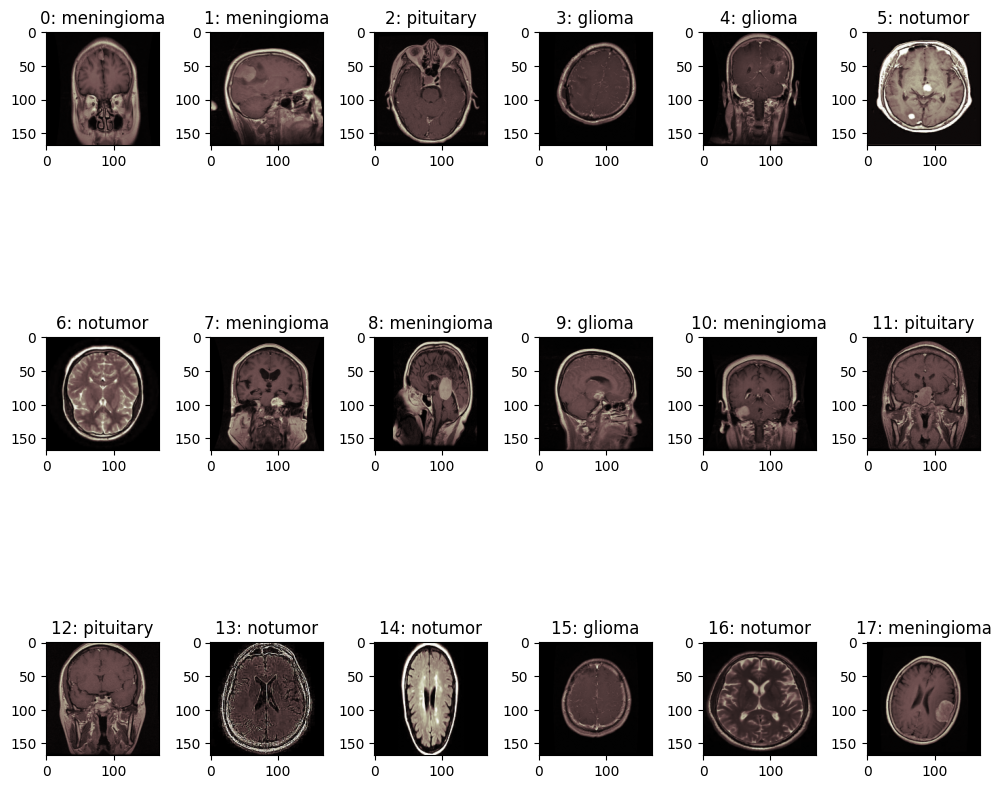

In [5]:
#randomly select 12 images from the train dataset and show their labels
random_numbers = random.sample(range(1, 5712), 18)
images = [x_train[i] for i in random_numbers]
fig, axes = plt.subplots(3, 6, figsize = (10, 10))
axes = axes.flatten()
index=0
for img, ax in zip(images, axes):
    ax.imshow(img)
    index1=random_numbers[index]
    title=train_index[index1]
    ax.set_title(f'{index}: {title}')
    index=index+1
plt.tight_layout()
plt.show()

In [6]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 
y_train = tf.keras.utils.to_categorical(y_train) 
y_test = tf.keras.utils.to_categorical(y_test)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) 
print(x_val.shape)

(1143, 168, 168, 3)


In [7]:
print(x_train.shape)

(4569, 168, 168, 3)


In [13]:
datagenerator = ImageDataGenerator(
    rotation_range=20,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    horizontal_flip=True)

In [14]:
datagenerator.fit(x_train)

In [15]:
def cnn(pretrained_weights=None, input_shape=(168,168,3)):
    model = Sequential()
    model.add(Conv2D(32, 4, activation = 'relu', padding = 'same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(32, 4, activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(64, 4, activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(4, activation='sigmoid'))
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

In [16]:
model=cnn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 168, 168, 32)      1568      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 84, 84, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 84, 84, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 84, 84, 32)        16416     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 42, 42, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 42, 42, 32)       

In [17]:
history = model.fit(datagenerator.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS)   

Epoch 1/50
229/229 [==============================] - 92s 399ms/step - loss: 0.4540 - acc: 0.5373 - val_loss: 0.3358 - val_acc: 0.7533
Epoch 2/50
229/229 [==============================] - 95s 416ms/step - loss: 0.3358 - acc: 0.7076 - val_loss: 0.2734 - val_acc: 0.7498
Epoch 3/50
229/229 [==============================] - 94s 411ms/step - loss: 0.2910 - acc: 0.7496 - val_loss: 0.2518 - val_acc: 0.7988
Epoch 4/50
229/229 [==============================] - 94s 411ms/step - loss: 0.2746 - acc: 0.7630 - val_loss: 0.2575 - val_acc: 0.7734
Epoch 5/50
229/229 [==============================] - 102s 444ms/step - loss: 0.2532 - acc: 0.7881 - val_loss: 0.2203 - val_acc: 0.8075
Epoch 6/50
229/229 [==============================] - 105s 458ms/step - loss: 0.2348 - acc: 0.8004 - val_loss: 0.1955 - val_acc: 0.8495
Epoch 7/50
229/229 [==============================] - 107s 468ms/step - loss: 0.2260 - acc: 0.8153 - val_loss: 0.1759 - val_acc: 0.8696
Epoch 8/50
229/229 [==============================] 

/var/folders/92/94j_st7j0d5b9dxv5gqwl7pm0000gn/T/ipykernel_31840/4215753566.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(history.history['acc'],'r',linewidth=3.0,marker='o', linestyle='-', color='green')
/var/folders/92/94j_st7j0d5b9dxv5gqwl7pm0000gn/T/ipykernel_31840/4215753566.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(history.history['val_acc'],'b',linewidth=3.0,marker='o', linestyle='-', color='orange')


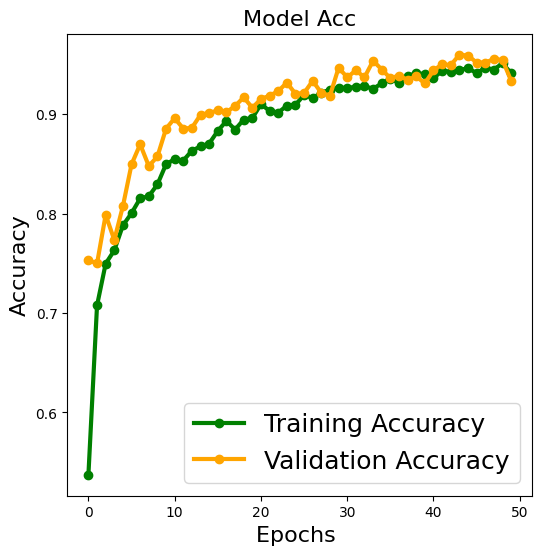

/var/folders/92/94j_st7j0d5b9dxv5gqwl7pm0000gn/T/ipykernel_31840/4215753566.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(history.history['loss'],'r',linewidth=3.0,marker='o', linestyle='-', color='blue')
/var/folders/92/94j_st7j0d5b9dxv5gqwl7pm0000gn/T/ipykernel_31840/4215753566.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(history.history['val_loss'],'b',linewidth=3.0, marker='o', linestyle='-', color='red')


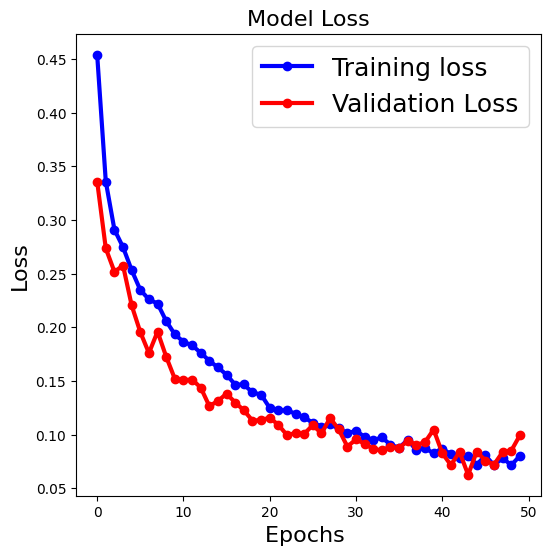

In [59]:
plt.figure(figsize=[6,6])
plt.plot(history.history['acc'],'r',linewidth=3.0,marker='o', linestyle='-', color='green')
plt.plot(history.history['val_acc'],'b',linewidth=3.0,marker='o', linestyle='-', color='orange')
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Model Acc',fontsize=16)   
plt.show()
plt.figure(figsize=[6,6])
plt.plot(history.history['loss'],'r',linewidth=3.0,marker='o', linestyle='-', color='blue')
plt.plot(history.history['val_loss'],'b',linewidth=3.0, marker='o', linestyle='-', color='red')
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Model Loss',fontsize=16)
plt.show()

<Axes: >

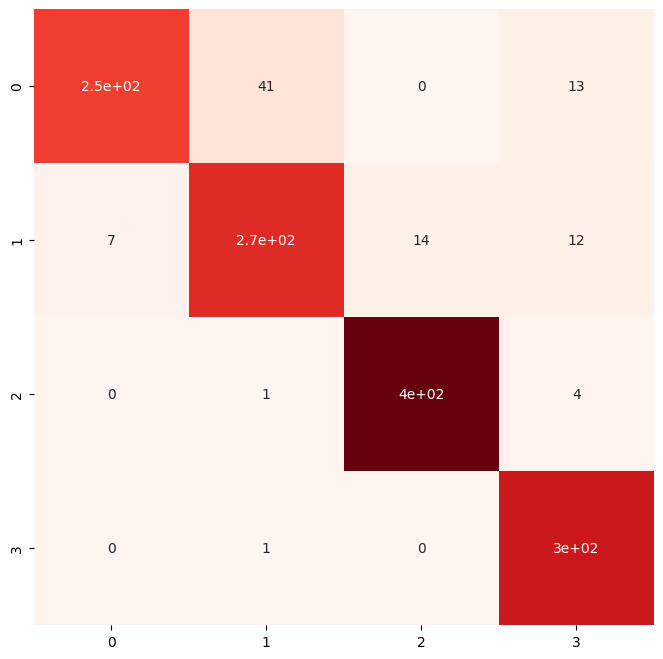

In [21]:
predicted_labels = np.argmax(predictions, axis = 1)
cm = confusion_matrix(np.argmax(y_test,axis=1), predicted_labels)
plt.figure(figsize = (8, 8))
sns.heatmap(cm, cmap ='Reds', annot = True, cbar = False)

In [57]:
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_scores = 2 * precision * recall / (precision + recall)
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print("Metrics for each class:")
for i in range(len(class_mappings)):
    class_name = labels[i]
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-Score: {f1_scores[i]:.4f}\n")

print(f"Overall Accuracy: {accuracy:.4f}")

Metrics for each class:
Class: glioma
Precision: 0.9723
Recall: 0.8200
F1-Score: 0.8897

Class: meningioma
Precision: 0.8639
Recall: 0.8922
F1-Score: 0.8778

Class: notumor
Precision: 0.9662
Recall: 0.9877
F1-Score: 0.9768

Class: pituitary
Precision: 0.9116
Recall: 0.9967
F1-Score: 0.9522

Overall Accuracy: 0.9291


In [19]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 5s 132ms/step - loss: 0.0906 - acc: 0.9291


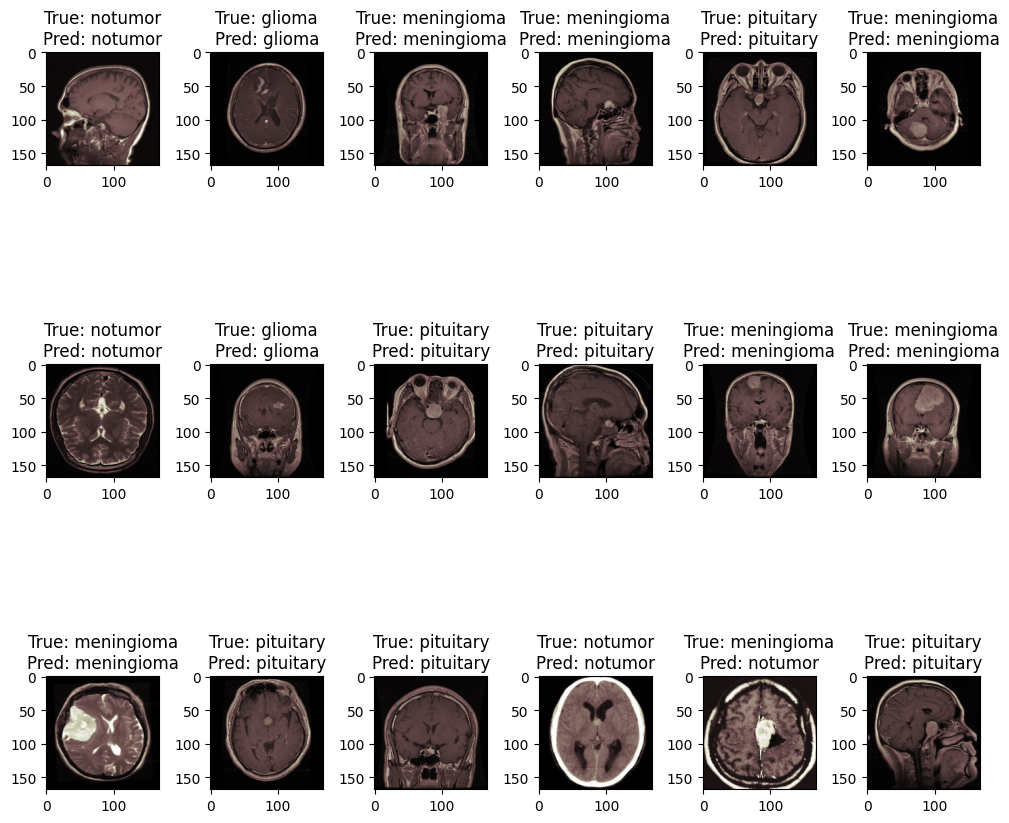

In [32]:
y_pred_final=[]
for list in predictions:
    if list[0]>0.5:
        y_pred_final.append('glioma')
    if list[1]>0.5:
        y_pred_final.append('meningioma')
    if list[2]>0.5:
        y_pred_final.append('notumor')
    if list[3]>0.5:
        y_pred_final.append('pituitary')
y_test_1=[]
for k in y_test:
    if k[0]>0:
        y_test_1.append('glioma')
    if k[1]>0:
        y_test_1.append('meningioma')
    if k[2]>0:
        y_test_1.append('notumor')
    if k[3]>0:
        y_test_1.append('pituitary')
random_numbers = random.sample(range(1, 1312), 18)
#images = [x_train[i] for i in random_numbers]
images = [x_test[i] for i in random_numbers]
fig, axes = plt.subplots(3, 6, figsize = (10, 10))
axes = axes.flatten()
index=0
for img, ax in zip(images, axes):
    image_index=random_numbers[index]
    true_class=y_test_1[image_index]
    predicted_class=y_pred_final[image_index]
    ax.imshow(img)
    ax.set_title(f"True: {true_class}\nPred: {predicted_class}")
    index=index+1 
plt.tight_layout()
plt.show()